This notebook runs autoencoder on VGG19 output before grouping them using KNN 

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as mx
import tensorflow as tf
import seaborn as sns
import random
import joblib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense
from tensorflow.keras import Sequential, Model,Input, layers
from keras.layers import ( MaxPooling2D, Dense, Flatten, 
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
# Base Libraries
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.models import Model
import numpy as np 
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Classification
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet # for Lasso and Elastic Net logistic regression
# from sklearn.cross_decomposition import PLSRegression # for PLS

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report
pd.set_option('display.max_colwidth', None)

In [5]:
vgg19_feature_severity = pd.read_csv('vgg19_feature_severity.csv',index_col=0)
vgg19_feature_severity

,id,severity,0,1,2,3,4,5,6,7,...,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799
0,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/erythrokeratodermia-variabilis-4.jpg,10,4.267727,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,4.790735,54.445866,0.000000,0.0,0.000000,0.000000,21.140205,0.0
1,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Psoriasis-Chronic-Plaque-13.jpg,10,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,8.161653,7.837052,10.883604,0.0,0.000000,0.000000,0.000000,0.0
2,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Lichen-Planus-Oral-28.jpg,5,0.000000,0.0,0.0,16.705368,12.607100,0.000000,2.40042,5.679642,...,25.521635,0.0,0.000000,10.020402,0.000000,0.0,36.357765,0.000000,2.955516,0.0
3,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Palmoplantar-Keratoderma-2.jpg,4,0.000000,0.0,0.0,1.627664,0.349453,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,12.166387,0.000000,0.0
4,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/08PsoriasisOnycholysis1.jpg,2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/reiter-syndrome-14.jpg,3,0.193476,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
463,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Lichen-Nitidus-15.jpg,4,7.712959,0.0,0.0,1.568991,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.788425,0.0
464,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Pityriasis-Lichenoides-15.jpg,7,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,4.699575,0.0
465,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/pityriasis-rosea-2.jpg,5,0.000000,0.0,0.0,0.000000,0.000000,16.200745,0.00000,0.000000,...,0.000000,0.0,1.399691,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [36]:
vgg19_feature_dermnet = vgg19_feature_severity.iloc[:, 2:].to_numpy()
vgg19_feature_dermnet.shape

(467, 12800)

## Run Autoencoder on VGG feature vector

In [39]:
input_img = Input(shape=(12800,))
encoded = layers.Dense(12800/2, activation='relu')(input_img)
encoded = layers.Dense(12800/4, activation='relu')(encoded)
encoded = layers.Dense(12800/8, activation='relu')(encoded)

decoded = layers.Dense(12800/4, activation='relu')(encoded)
decoded = layers.Dense(12800/2, activation='relu')(decoded)
decoded = layers.Dense(12800, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(vgg19_feature_dermnet, vgg19_feature_dermnet, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

# Compress features using the encoder
compressed_features = autoencoder.predict(vgg19_feature_dermnet)
print(compressed_features.shape) 

Epoch 1/10
12/12 [==============================] - 4s 191ms/step - loss: 73.5846 - val_loss: 71.6303
Epoch 2/10
12/12 [==============================] - 2s 181ms/step - loss: 73.4448 - val_loss: 71.6313
Epoch 3/10
12/12 [==============================] - 2s 191ms/step - loss: 73.4454 - val_loss: 71.6318
Epoch 4/10
12/12 [==============================] - 2s 183ms/step - loss: 73.4462 - val_loss: 71.6325
Epoch 5/10
12/12 [==============================] - 2s 203ms/step - loss: 73.4468 - val_loss: 71.6327
Epoch 6/10
12/12 [==============================] - 2s 191ms/step - loss: 73.4469 - val_loss: 71.6327
Epoch 7/10
12/12 [==============================] - 2s 204ms/step - loss: 73.4470 - val_loss: 71.6314
Epoch 8/10
12/12 [==============================] - 2s 181ms/step - loss: 73.4459 - val_loss: 71.6307
Epoch 9/10
12/12 [==============================] - 2s 197ms/step - loss: 73.4451 - val_loss: 71.6310
Epoch 10/10
15/15 [==============================] - 1s 40ms/step
(467, 12800)


In [34]:
joblib.dump(autoencoder, 'autoencoder/autoencoder_simple_100_epoch.pkl')

['autoencoder/autoencoder_simple_100_epoch.pkl']

In [52]:
# Encoder model
encoder = Model(input_img, encoded)

# Print the encoder summary to verify the architecture
print(encoder.summary())

# Use the encoder to transform the input data into the compressed feature vectors
encoded_features_DermNet = encoder.predict(vgg19_feature_dermnet)

# Print the shape of the encoded features
print("Shape of encoded features:", encoded_features_DermNet.shape)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 12800)]           0         
                                                                 
 dense_78 (Dense)            (None, 6400)              81926400  
                                                                 
 dense_79 (Dense)            (None, 3200)              20483200  
                                                                 
 dense_80 (Dense)            (None, 1600)              5121600   
                                                                 
Total params: 107531200 (410.20 MB)
Trainable params: 107531200 (410.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
15/15 [==============================] - 0s 21ms/step
Shape of encoded features: (467, 1600)


# KNN Cluster of entire Dermnet

In [53]:
from sklearn.neighbors import NearestNeighbors

# Assuming your data is stored in a variable named 'data'
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(encoded_features_DermNet) # it automatically selects 'brute' for auto
distances, indices = nbrs.kneighbors(encoded_features_DermNet)

In [54]:
nbrs.kneighbors_graph(encoded_features_DermNet).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [59]:
# Convert each row to a tuple, sort the tuple, and then create a set
unique_tuples = set(tuple(sorted(row)) for row in indices)

# Convert the set back to a NumPy array
unique_indices = np.array(list(unique_tuples))

print(unique_indices.shape)

# Get the indices that would sort the array along the first column
sorted_indices = np.argsort(unique_indices[:, 0])

# Use the sorted indices to reorder the array
sorted_pairs = unique_indices[sorted_indices]

sorted_pairs_df = pd.DataFrame(sorted_pairs)
sorted_pairs_df.columns = ["ImageA", "ImageB"]
sorted_pairs_df

(327, 2)


,ImageA,ImageB
0,0,75
1,1,341
2,2,157
3,3,179
4,4,149
...,...,...
322,428,429
323,438,458
324,441,462
325,443,450


In [78]:
# Function to categorize values
def categorize_value(value):
    if value > 0:
        return 'Worsened'
    elif value < 0:
        return 'Improved'
    else:
        return 'No change'

# functions that take KNN indices of the pairs & dataframe containing image name and severity, to output 
    # 1) the dataframe containing pairs of images and their severity labels and progression
    # 2) feature difference for the pairs 
def KNN_result_to_labelled_df(KNN_indices, vgg19_feature_severity_df):

    # Create sorted pairs df
    # Convert each row to a tuple, sort the tuple, and then create a set
    unique_tuples = set(tuple(sorted(row)) for row in KNN_indices)

    # Convert the set back to a NumPy array
    unique_indices = np.array(list(unique_tuples))


    # Get the indices that would sort the array along the first column
    sorted_indices = np.argsort(unique_indices[:, 0])

    # Use the sorted indices to reorder the array
    sorted_pairs = unique_indices[sorted_indices]

    sorted_pairs_df = pd.DataFrame(sorted_pairs)
    sorted_pairs_df.columns = ["ImageA", "ImageB"]

    # Add Image A info
    # Merge dataframes on the common index
    merged_df = pd.merge(sorted_pairs_df, vgg19_feature_severity_df.iloc[:, :2], left_on='ImageA', right_index=True, how='left')
    merged_df['SeverityA'] = merged_df['severity']
    merged_df['ImageA_name'] = merged_df['id']
    merged_df = merged_df.drop(['id', 'severity'], axis=1)

    # Add Image B info
    # Merge dataframes on the common index
    merged_df = pd.merge(merged_df, vgg19_feature_severity_df.iloc[:, :2], left_on='ImageB', right_index=True, how='left')
    merged_df['SeverityB'] = merged_df['severity']
    merged_df['ImageB_name'] = merged_df['id']
    merged_df = merged_df.drop(['id', 'severity'], axis=1)

    merged_df['SeverityB - SeverityA'] = merged_df['SeverityB'] - merged_df['SeverityA']
    
    # Apply the function to create a new categorical column
    merged_df['Progression'] = merged_df['SeverityB - SeverityA'].apply(categorize_value)

    display(merged_df.head())
    print(merged_df.shape)

    # Get feature difference 
    ImageA_feature = np.array(vgg19_feature_severity_df.iloc[merged_df['ImageA'], 2:])
    ImageB_feature = np.array(vgg19_feature_severity_df.iloc[merged_df['ImageB'], 2:])
    feature_difference = ImageB_feature - ImageA_feature
    print('shape of feature difference is', feature_difference.shape)

    return merged_df, feature_difference

In [79]:
KNN_pair_autoencoder, feature_diff_KNN_autoencoder = KNN_result_to_labelled_df(indices, vgg19_feature_severity)

,ImageA,ImageB,SeverityA,ImageA_name,SeverityB,ImageB_name,SeverityB - SeverityA,Progression
0,0,75,10,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/erythrokeratodermia-variabilis-4.jpg,12,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Psoriasis-inversus-21.jpg,2,Worsened
1,1,341,10,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Psoriasis-Chronic-Plaque-13.jpg,5,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/08SebDermEar1.jpg,-5,Improved
2,2,157,5,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Lichen-Planus-Oral-28.jpg,12,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Psoriasis-Hand-27.jpg,7,Worsened
3,3,179,4,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Palmoplantar-Keratoderma-2.jpg,4,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/psoriasis-palms-soles-17.jpg,0,No change
4,4,149,2,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/08PsoriasisOnycholysis1.jpg,1,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/lichen-planus-82.jpg,-1,Improved


(327, 8)
shape of feature difference is (327, 12800)


In [ ]:
X_dermnet_autoencoder = feature_diff_KNN_autoencoder
y_dermnet_autoencoder = KNN_pair_autoencoder['Progression']
joblib.dump([X_dermnet_autoencoder, y_dermnet_autoencoder], 'X_y_dermnet_autoencoder.pkl')

# Train RF on Dermnet Autoencoder

In [83]:
import joblib
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report

def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)

def predict_from_pkl(pkl,x,y):
    model = joblib.load(pkl)
    y_pred = model.predict(Feature_difference)
    print(classification_report(y, y_pred))
    print('accuracy:', accuracy_score(y, y_pred))

    cm_default = confusion_matrix(y, y_pred)
    conf_matrix_heatmap(cm_default)
    return y_pred

def run_random_forest(X_train, y_train, X_test, y_test, quality_scores, CID = 5):
    RF =  RandomForestClassifier(
        n_estimators=1000, 
        criterion='entropy', 
        oob_score=True, 
        class_weight='balanced',
        random_state=CID)
    
    RF.fit(X_train, y_train, sample_weight=quality_scores)
    y_RF = RF.predict(X_test) 

    # classification report 
    print(classification_report(y_test, y_RF)) 
    print('accuracy:', accuracy_score(y_test, y_RF))
    cm_default = confusion_matrix(y_test, y_RF)
    display(conf_matrix_heatmap(cm_default))

In [82]:
X_dermnet, y_dermnet = joblib.load('dermnet_X_y.pkl')
X_PASI, y_PASI = joblib.load('PASI_X_y.pkl')
X_train_paper, X_test_paper, y_train_paper,y_test_paper,X_paper,y_paper = joblib.load('Paper_X_y_train_test.pkl')
X_dermnet_autoencoder, y_dermnet_autoencoder = joblib.load('X_y_dermnet_autoencoder.pkl')

              precision    recall  f1-score   support

    Improved       0.40      1.00      0.57         6
   No change       0.00      0.00      0.00         0
    Worsened       1.00      0.38      0.55        16

    accuracy                           0.55        22
   macro avg       0.47      0.46      0.37        22
weighted avg       0.84      0.55      0.55        22

accuracy: 0.5454545454545454


/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


None

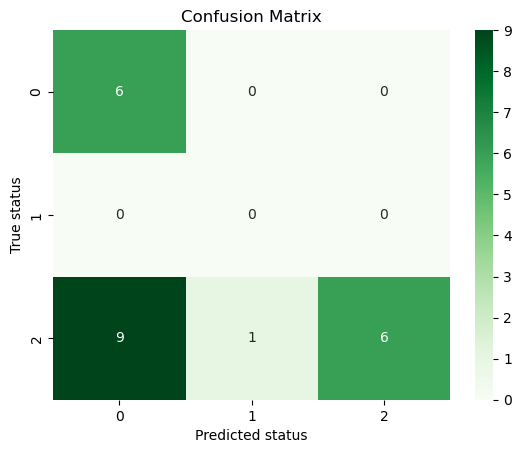

In [86]:
# Test on Test progression images
quality_scores = np.repeat(1, X_dermnet_autoencoder.shape[0]) # put 1x weight on samples in PASI compared to samples in Dermnet
run_random_forest(X_dermnet_autoencoder, y_dermnet_autoencoder,X_test_paper,y_test_paper,quality_scores)

## Train on Dermnet_autoencoder + paper_train and test on paper test

(359, 12800)
(359,)
              precision    recall  f1-score   support

    Improved       0.43      1.00      0.60         6
   No change       0.00      0.00      0.00         0
    Worsened       1.00      0.44      0.61        16

    accuracy                           0.59        22
   macro avg       0.48      0.48      0.40        22
weighted avg       0.84      0.59      0.61        22

accuracy: 0.5909090909090909


/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


None

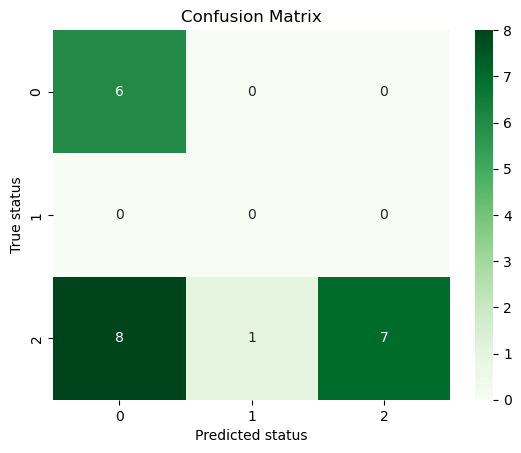

In [89]:
X_dermnet_autoencoder_paper_train = pd.concat([X_train_paper, pd.DataFrame(X_dermnet_autoencoder, columns=X_train_paper.columns)], axis=0, ignore_index=True)
print(X_dermnet_autoencoder_paper_train.shape)
y_dermnet_autoencoder_paper_train = pd.concat([y_train_paper, y_dermnet_autoencoder], axis=0)
print(y_dermnet_autoencoder_paper_train.shape)

quality_scores = np.repeat([5,1], [X_train_paper.shape[0], X_dermnet_autoencoder.shape[0]] ) 
run_random_forest(X_dermnet_autoencoder_paper_train, y_dermnet_autoencoder_paper_train,X_test_paper,y_test_paper,quality_scores)